Epoch 1/100


/Users/bhagya/Desktop/code/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1216
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0656
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0243
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0349
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0389
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0242
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0195
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0257
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0291
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0275
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0268
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0240
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0225
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0221
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0208
Epoch 16/100
2/2 ━━━━━━━━━━━━━━

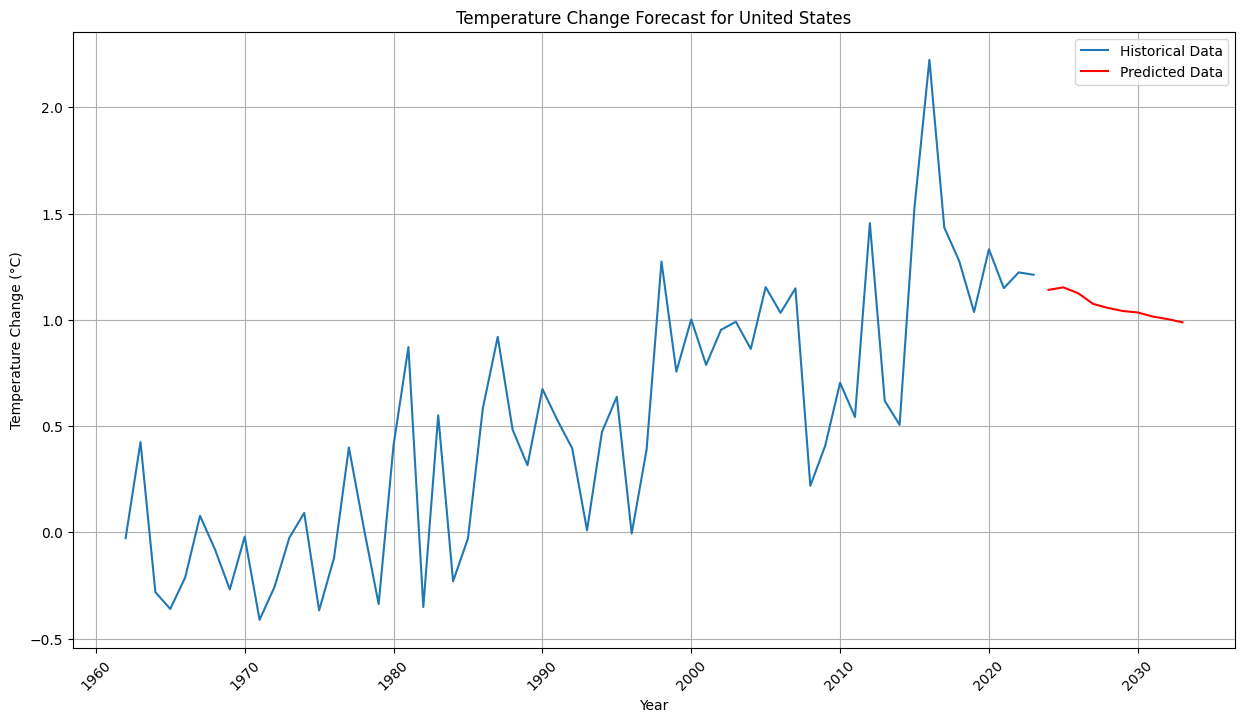

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the dataset
data = pd.read_csv('cl.csv')

# Function to get country data
def get_country_data(country_name):
    # Extract temperature data for the specified country
    country_data = data[data['Country'] == country_name].iloc[0]
    temp_data = country_data.iloc[11:]
    temp_data = pd.to_numeric(temp_data, errors='coerce')  # Convert to numeric, handle any non-numeric values
    return temp_data

# Function to prepare data for LSTM model (window-based approach)
def prepare_lstm_data(data, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])  # Predict the next temperature value
    X = np.array(X)
    y = np.array(y)
    return X, y

# Function to build and train a more complex LSTM model (stacked LSTM with Dropout)
def build_lstm_model(X_train, y_train, sequence_length):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))  # Dropout to avoid overfitting
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer with 1 unit for predicting temperature
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)
    return model

# Function to predict future temperatures and visualize results
def predict_and_visualize(country_name, years_to_predict=10, sequence_length=10):
    # Get historical temperature data for the country
    temp_data = get_country_data(country_name)

    # Rescale the data for LSTM model (values between 0 and 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    temp_data_scaled = scaler.fit_transform(temp_data.values.reshape(-1, 1))

    # Prepare data for training the LSTM model
    X, y = prepare_lstm_data(temp_data_scaled, sequence_length)

    # Reshape X to be in the format [samples, time_steps, features] for LSTM input
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split the data into training (80%) and testing (20%) sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build and train the LSTM model
    model = build_lstm_model(X_train, y_train, sequence_length)

    # Use the last sequence of data for predictions
    last_sequence = temp_data_scaled[-sequence_length:].reshape(1, sequence_length, 1)

    # Predict the future temperatures (next 'years_to_predict' years)
    future_predictions_scaled = []
    for _ in range(years_to_predict):
        predicted = model.predict(last_sequence)
        future_predictions_scaled.append(predicted[0][0])
        last_sequence = np.append(last_sequence[:, 1:, :], predicted.reshape(1, 1, 1), axis=1)

    # Inverse transform the predictions to the original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

    # Get the years based on the column names (assuming they are years from 1961 onwards)
    years = temp_data.index.astype(int)  # Convert the index to integers
    last_year = years[-1]  # Get the last year from the dataset
    
    # Create the future years (last year + 1 to last year + years_to_predict)
    future_years = np.arange(last_year + 1, last_year + years_to_predict + 1)
    
    # Create a DataFrame with future predictions
    future_predictions_df = pd.DataFrame(future_predictions, index=future_years, columns=['Predicted Temperature Change'])

    # Plotting the historical data and predictions
    plt.figure(figsize=(15, 8))
    sns.lineplot(x=years, y=temp_data.values, label='Historical Data')
    sns.lineplot(x=future_predictions_df.index, y=future_predictions_df.values.flatten(), label='Predicted Data', color='red')
    plt.title(f'Temperature Change Forecast for {country_name}')
    plt.xlabel('Year')
    plt.ylabel('Temperature Change (°C)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example: Predict temperature change for India for the next 10 years
predict_and_visualize('United States', years_to_predict=10)
